# Construção do modelo ARIMA

## Bibliotecas necessárias

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA

## Leitura dos dados

In [6]:
covid_data.columns

Index(['Unnamed: 0', 'Date', 'Country/Region', 'Confirmed', 'Deaths',
       'Recovered', 'Active', 'New cases', 'New deaths', 'New recovered',
       'WHO Region'],
      dtype='object')

In [8]:
dir_covid_data = '../../datalake/silver/covid_data/'
covid_file = f'{dir_covid_data}/full_grouped_filtro_1.csv'
covid_data = pd.read_csv(covid_file)
covid_data.drop('Unnamed: 0', axis=1, inplace=True)
covid_data['Date'] = pd.to_datetime(covid_data['Date'])
covid_data.set_index('Date', inplace=True)
# daily_cases = covid_data.groupby('Country/Region')['Confirmed'].diff(1)
# daily_deaths = covid_data.groupby('Country/Region')['Deaths'].diff(1)
# daily_recovered = covid_data.groupby('Country/Region')['Recovered'].diff(1)
# daily_active = covid_data.groupby('Country/Region')['Active'].diff(1)

# covid_data['DailyCases'] = daily_cases # Número de casos diários
# covid_data['DailyDeaths'] = daily_deaths # Número de mortes diárias
# covid_data['DailyRecovered'] = daily_recovered # Número de casos recuperados diários
# covid_data['DailyActive'] = daily_active # Número de casos ativos diário

# # Dados necessários para o ARIMA
reg_data = covid_data[['Country/Region', 'New cases']].dropna() # Remoção de valores NaN

Função para gerar os modelos AR, MA e ARIMA

In [16]:
def arima_model(train_data, test_data, p=0, d=0, q=0, country='', model_name=''):
    model = ARIMA(train_data['New cases'], order=(p, d, q))
    model = model.fit()
    print(model.summary())
    
    fcst = pd.DataFrame([])
    data = train_data.copy()
    pred = model.predict(start=0, end=len(train_data['New cases'])-1)
    
    for i in range(len(test_data)):
        fcst = pd.concat([fcst, model.forecast()])
        data = pd.concat([data, test_data.iloc[i:i+1]])
        model_test = ARIMA(data['New cases'], order=(p, d, q))
        model = model_test.smooth(model.params)
    
    fig, ax = plt.subplots(1, 1, figsize=(10,6))
    plt.plot(train_data['New cases'], label='Dados de treino')
    plt.plot(pred, label='Treino predito')
    plt.plot(fcst, label='Previstos da série teste')
    plt.plot(test_data, label='Série de teste')
    plt.legend()
    plt.title(f'Modelo {model_name} para o {country}');
    

## Modelagem por país

### ARGENTINA

#### Configuração dos dados para o modelo.

Seleção dos dados de casos diários referentes a Argentina.

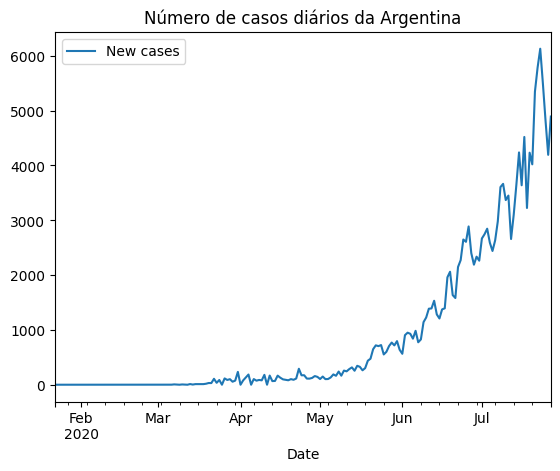

In [10]:
reg_data_ar = reg_data[reg_data['Country/Region'] == 'Argentina']
reg_data_ar = reg_data_ar[['New cases']]
reg_data_ar.plot()
plt.title('Número de casos diários da Argentina');

In [20]:
reg_data_ar.head()

,DailyCases
Date,
2020-01-23,0.0
2020-01-24,0.0
2020-01-25,0.0
2020-01-26,0.0
2020-01-27,0.0


No início da série existem vários valores iguais a zero. A existência desses valores zeros no início da série é devido a inesistência de COVID no começo. A série de casos de COVID começa, de fato, a partir do momento em que é registrado o primeiro caso. Assim, foram removidos os registros nulos anteriores a data em que aparece o primeiro registro de casos.

Remoção dos primeiros registros nulos.

<AxesSubplot:xlabel='Date'>

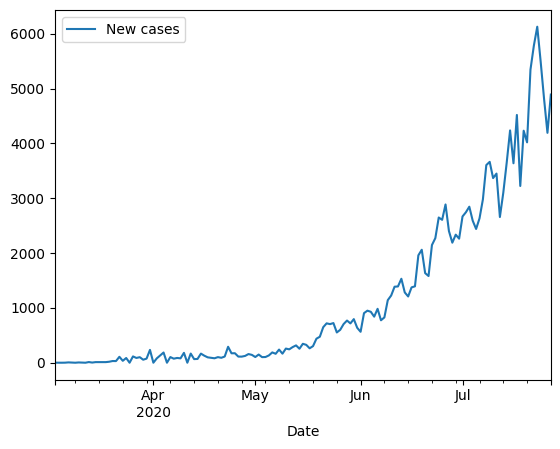

In [11]:
reg_data_ar = reg_data_ar.loc[reg_data_ar.ne(0).idxmax()[0]:]
reg_data_ar.plot()

In [22]:
reg_data_ar.head()

,DailyCases
Date,
2020-03-03,1.0
2020-03-04,0.0
2020-03-05,0.0
2020-03-06,1.0
2020-03-07,6.0


Vê-se então que, para o caso da Argentina, a pandemia de COVID inicou em 3 de março de 2020.

Serão separados os 70% primeiros registros para treino do modelo e o restante para teste. 
A seguir a quantidade de registros para os grupos de treino e teste.

In [12]:
print('Total de registros:', len(reg_data_ar))
print('Número de registros para treino:', round(len(reg_data_ar)*0.7, 0))
print('Número de registros para teste:', round(len(reg_data_ar)*0.3, 0))

Total de registros: 147
Número de registros para treino: 103.0
Número de registros para teste: 44.0


Separação dos grupos de treino e teste para a Argentina.

In [14]:
train_data = reg_data_ar.iloc[:103]
test_data = reg_data_ar.iloc[103:]
print('Número de registros para treino final:', len(train_data))
print('Número de registros para teste final:', len(test_data))

Número de registros para treino final: 103
Número de registros para teste final: 44


Antes de implementar o modelo ARIMA completo serão testadas duas variações, mais simples do mesmo. O modelo AR (autoregressivo) e o modelo MA (médias móveis).

#### Modelo AR (Auto Regressivo)

Para o modelo AR é necessário saber o valor do termo autoregressivo. Tal termo é obtido a partir da análise da autocorrelação parcial da série. A seguir é plotado o gráfico da autocorrelação parcial para a Argentina.

C:\Users\duart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


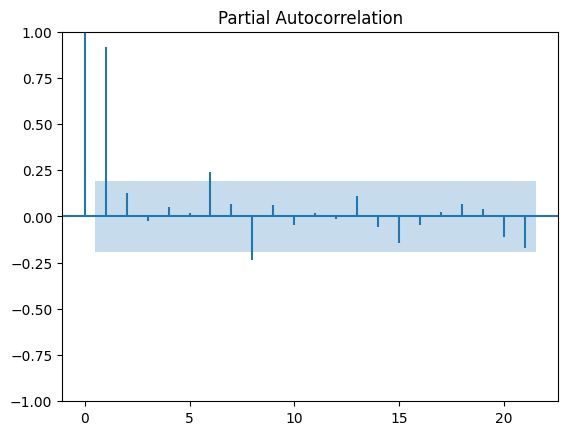

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_data['New cases'], marker='');

Segundo o gráfico acima o termo autoregressivo de significância estatística é o de ordem 1. Assim o modelo AR a ser construído será de ordem 1. O método ARIMA do statsmodels permite construir modelos AR definido apenas o valor do termo Autoregressivo e definido o valor dos outros termos do modelo como sendo iguais a zero.

                               SARIMAX Results                                
Dep. Variable:              New cases   No. Observations:                  103
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -613.555
Date:                Fri, 09 Dec 2022   AIC                           1233.110
Time:                        21:16:15   BIC                           1241.014
Sample:                    03-03-2020   HQIC                          1236.311
                         - 06-13-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        294.2678   1201.884      0.245      0.807   -2061.382    2649.917
ar.L1          0.9913      0.020     48.439      0.000       0.951       1.031
sigma2      8406.9174    831.335     10.113      0.0

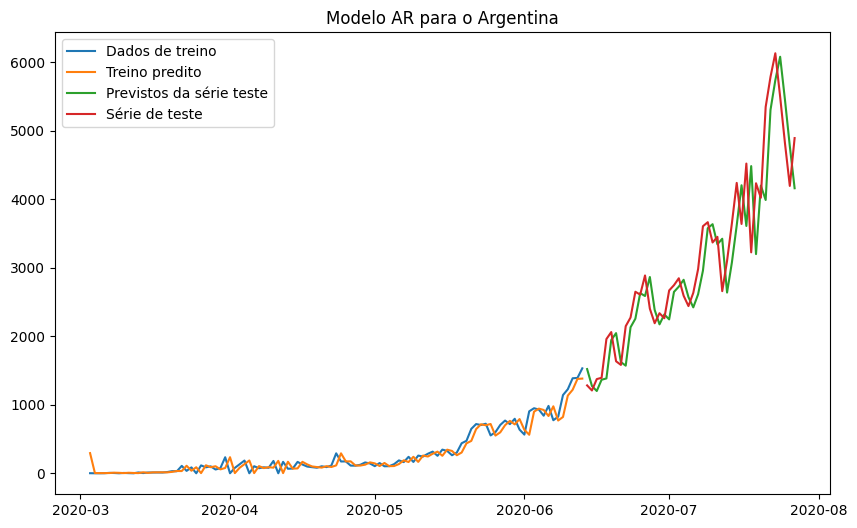

In [17]:
# Definição do modelo AR para a Argentina
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")
arima_model(train_data, test_data, p=1, model_name='AR', country='Argentina')

Gráfico de comparação entre o modelado e o observado. Neste caso o modelo utiliza dados do dia anterior (AR de ordem 1) e prevê para 1 dia. 

#### Modelo MA (Médias Móveis)

Assim como o AR é necessário calcular o termo de MA. Tal termo pode ser obtido a partir da análise do gráfico de autocorrelação a seguir.

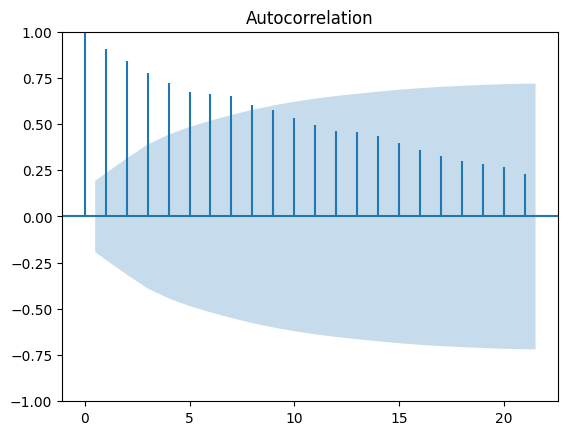

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train_data['New cases'],  marker='');

Segundo o gráfico acima o termo MA para o modelo é 7. Pois, a correlação dos 7 primeiros lags está acima do intervalo de confiança de 95% (área sombreada). 

                               SARIMAX Results                                
Dep. Variable:              New cases   No. Observations:                  103
Model:                 ARIMA(0, 0, 7)   Log Likelihood                -639.587
Date:                Fri, 09 Dec 2022   AIC                           1297.174
Time:                        21:16:35   BIC                           1320.887
Sample:                    03-03-2020   HQIC                          1306.779
                         - 06-13-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        294.5902     96.744      3.045      0.002     104.975     484.206
ma.L1          0.9975     22.520      0.044      0.965     -43.140      45.135
ma.L2          1.0711     11.100      0.096      0.9

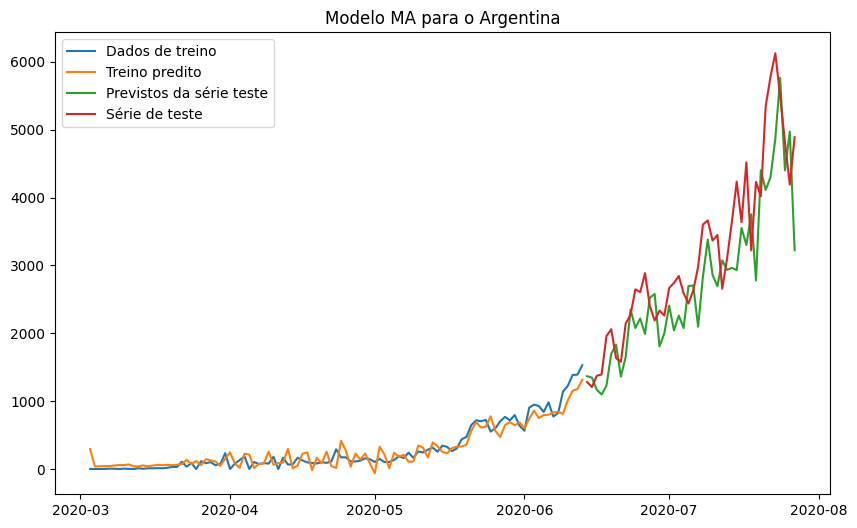

In [19]:
arima_model(train_data, test_data, q=7, model_name='MA', country='Argentina')

Considerando o AIC o AR obteve melhor resultado que o MA pois obteve AIC menor.

Nítidamente o modelo AR foi superior ao MA.

#### Modelo ARIMA

Da mesma forma que os modelos anteriores os AR e MA é necessário estimar os valores dos termos do modelo.
Além dos termos AR e MA o ARIMA tabém conta com o termo de diferenciação (d).
A diferenciação é utilizada para transformar a série temporal em uma série estacionária.
O teste de Fuller é um dos métodos utilizados para estimar se uma série temporal é estacionária ou não.

In [20]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(train_data['New cases'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 3.310464
p-value: 1.000000


Como o resultado o p-valor é superior a 0,05 pode-se descartar a hipótese de que a série e estacionária e por isso será necessário diferenciar a série até que se obtenha uma série estacionária como se segue.

In [21]:
def plot_diffs():
    # Original Series
    fig, axes = plt.subplots(4, 3, figsize=(20, 10))
    axes[0, 0].plot(train_data['New cases']); 
    axes[0, 0].set_title('Original Series')
    plot_acf(train_data['New cases'], ax=axes[0, 1], marker='')
    plot_pacf(train_data['New cases'], ax=axes[0, 2], marker='')
    result = adfuller(train_data['New cases'])
    print('ADF Statistic 0 Order: %f' % result[0])
    print('p-value: %f' % result[1])


    # 1st Differencing
    axes[1, 0].plot(train_data['New cases'].diff()); 
    axes[1, 0].set_title('1st Order Differencing')
    plot_acf(train_data['New cases'].diff().dropna(), ax=axes[1, 1], marker='')
    plot_pacf(train_data['New cases'].diff().dropna(), ax=axes[1, 2], marker='')
    result = adfuller(train_data['New cases'].diff().dropna())
    print('ADF Statistic 1st Order: %f' % result[0])
    print('p-value: %f' % result[1])


    # # 2nd Differencing
    axes[2, 0].plot(train_data['New cases'].diff().diff()); 
    axes[2, 0].set_title('2nd Order Differencing')
    plot_acf(train_data['New cases'].diff().diff().dropna(), ax=axes[2, 1], marker='')
    plot_pacf(train_data['New cases'].diff().diff().dropna(), ax=axes[2, 2], marker='')
    result = adfuller(train_data['New cases'].diff().diff().dropna())
    print('ADF Statistic 2nd Order: %f' % result[0])
    print('p-value: %f' % result[1])

    # # 3th Differencing
    axes[3, 0].plot(train_data['New cases'].diff().diff().diff()); 
    axes[3, 0].set_title('3nd Order Differencing')
    plot_acf(train_data['New cases'].diff().diff().diff().dropna(), ax=axes[3, 1], marker='')
    plot_pacf(train_data['New cases'].diff().diff().diff().dropna(), ax=axes[3, 2], marker='')
    result = adfuller(train_data['New cases'].diff().diff().diff().dropna())
    print('ADF Statistic 3th order: %f' % result[0])
    print('p-value: %f' % result[1])

    plt.show()
    

ADF Statistic 0 Order: 3.310464
p-value: 1.000000
ADF Statistic 1st Order: -2.056910
p-value: 0.262190
ADF Statistic 2nd Order: -7.250417
p-value: 0.000000
ADF Statistic 3th order: -7.106672
p-value: 0.000000


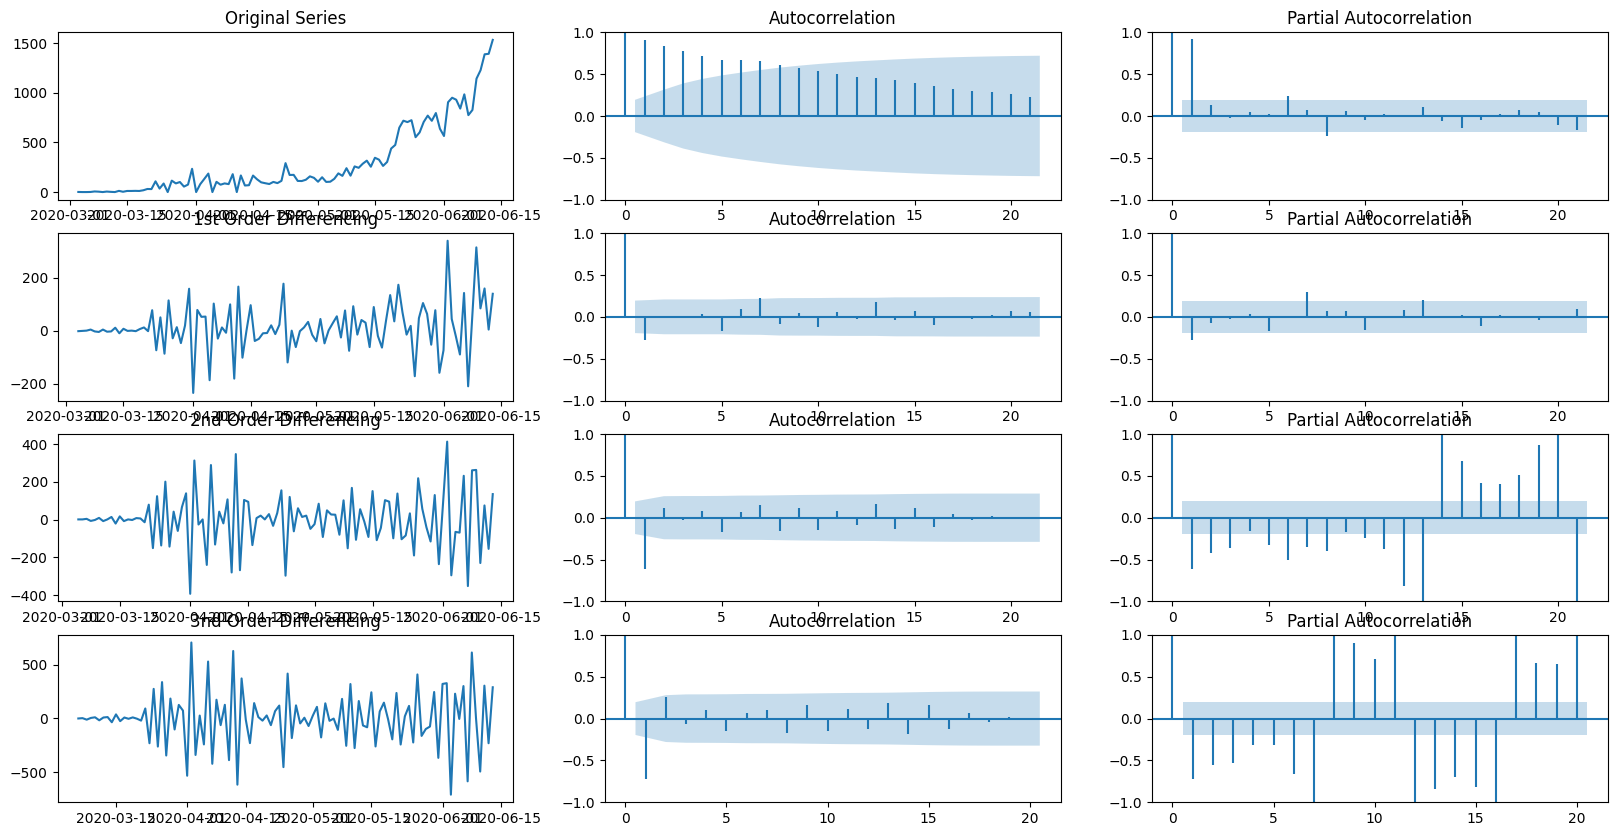

In [22]:
plot_diffs()

Com a diferenciação de segunda ordem já se obteve uma série temporal. O termo MA será 1. O termo AR será de 3.

                               SARIMAX Results                                
Dep. Variable:              New cases   No. Observations:                  103
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -595.272
Date:                Fri, 09 Dec 2022   AIC                           1200.545
Time:                        21:18:27   BIC                           1213.620
Sample:                    03-03-2020   HQIC                          1205.838
                         - 06-13-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3636      0.102     -3.557      0.000      -0.564      -0.163
ar.L2         -0.1571      0.080     -1.963      0.050      -0.314      -0.000
ar.L3         -0.0931      0.114     -0.817      0.4

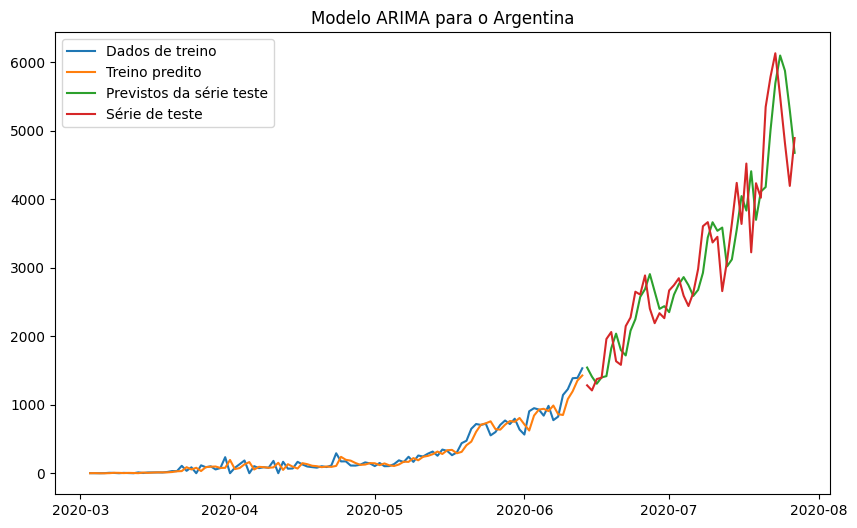

In [23]:
arima_model(train_data, test_data, p=3, d=2, q=1, model_name='ARIMA', country='Argentina')

A redução do AIC indica que o ARIM(3, 2, 1) têm desempenho melhor que o AR(1).

A seguir seguem os mesmos procedimentos para os demais países.

### México

#### Preparação dos dados

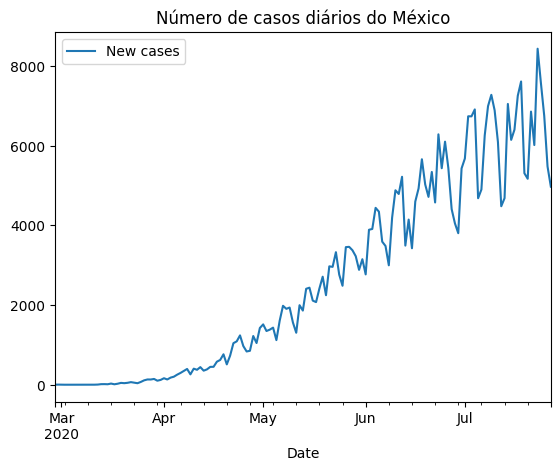

In [24]:
reg_data_mx = reg_data[reg_data['Country/Region'] == 'Mexico']
reg_data_mx = reg_data_mx[['New cases']]
reg_data_mx = reg_data_mx.loc[reg_data_mx.ne(0).idxmax()[0]:]
reg_data_mx.plot()
plt.title('Número de casos diários do México');

In [25]:
print('Total de registros:', len(reg_data_mx))
print('Número de registros para treino:', round(len(reg_data_mx)*0.7, 0))
print('Número de registros para teste:', round(len(reg_data_mx)*0.3, 0))

Total de registros: 151
Número de registros para treino: 106.0
Número de registros para teste: 45.0


In [26]:
train_data = reg_data_mx.iloc[:106]
test_data = reg_data_mx.iloc[106:]
print('Número de registros para treino final:', len(train_data))
print('Número de registros para teste final:', len(test_data))

Número de registros para treino final: 106
Número de registros para teste final: 45


#### Modelo AR (Autoregressivo)

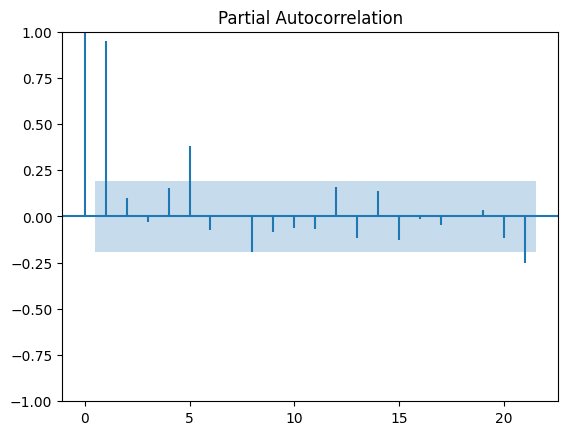

In [27]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_data['New cases'], marker='');

                               SARIMAX Results                                
Dep. Variable:              New cases   No. Observations:                  106
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -758.000
Date:                Fri, 09 Dec 2022   AIC                           1521.999
Time:                        21:19:10   BIC                           1529.990
Sample:                    02-28-2020   HQIC                          1525.238
                         - 06-12-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1313.1985   5717.909      0.230      0.818   -9893.697    1.25e+04
ar.L1          0.9915      0.030     33.464      0.000       0.933       1.050
sigma2      9.166e+04   8231.532     11.135      0.0

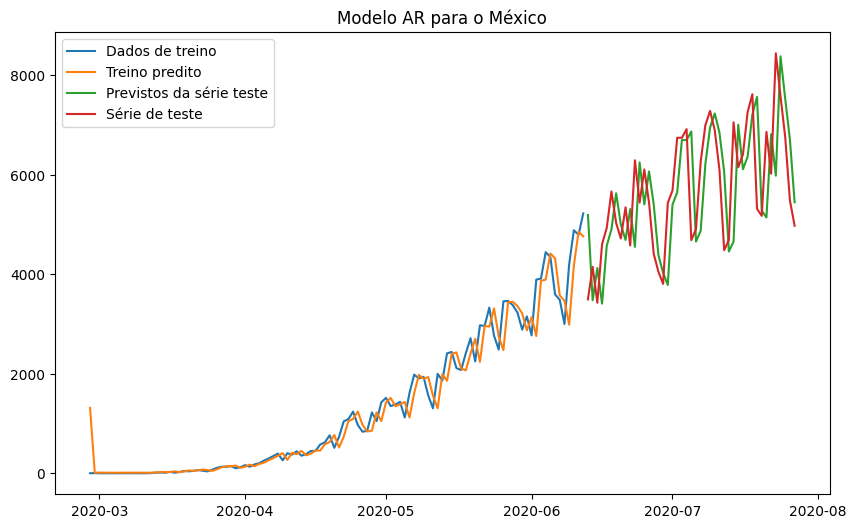

In [28]:
arima_model(train_data, test_data, p=1, model_name='AR', country='México')

#### Modelo MA (Médias Móveis)

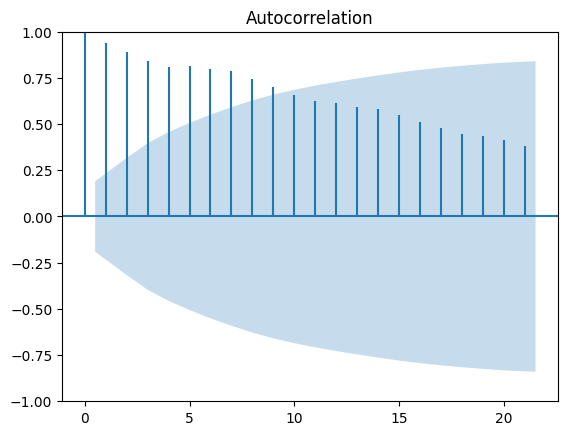

In [29]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train_data['New cases'],  marker='');

                               SARIMAX Results                                
Dep. Variable:              New cases   No. Observations:                  106
Model:                 ARIMA(0, 0, 9)   Log Likelihood                -823.642
Date:                Fri, 09 Dec 2022   AIC                           1669.284
Time:                        21:19:23   BIC                           1698.581
Sample:                    02-28-2020   HQIC                          1681.158
                         - 06-12-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1314.4680    519.861      2.528      0.011     295.559    2333.377
ma.L1          0.7448     81.853      0.009      0.993    -159.685     161.174
ma.L2          0.8811     79.469      0.011      0.9

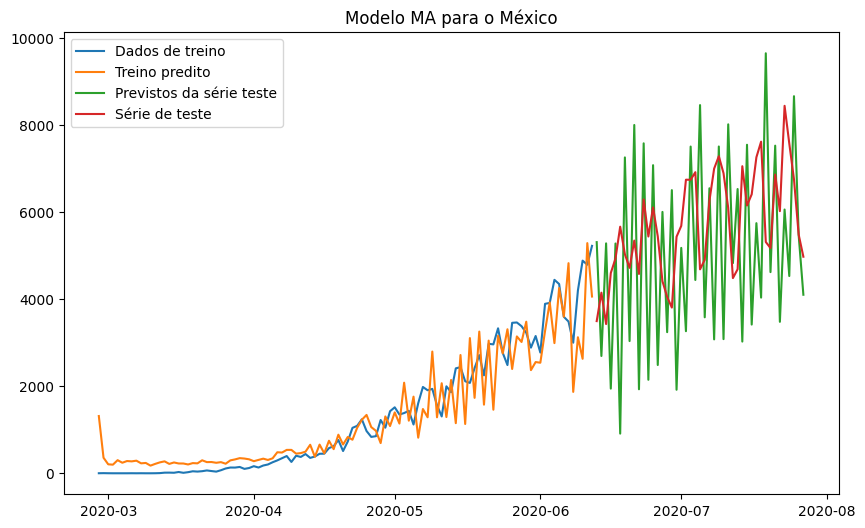

In [30]:
arima_model(train_data, test_data, q=9, model_name='MA', country='México')

#### Modelo ARIMA

In [31]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(train_data['New cases'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 3.006909
p-value: 1.000000


ADF Statistic 0 Order: 3.006909
p-value: 1.000000
ADF Statistic 1st Order: -1.243412
p-value: 0.654648
ADF Statistic 2nd Order: -7.129774
p-value: 0.000000
ADF Statistic 3th order: -7.026064
p-value: 0.000000


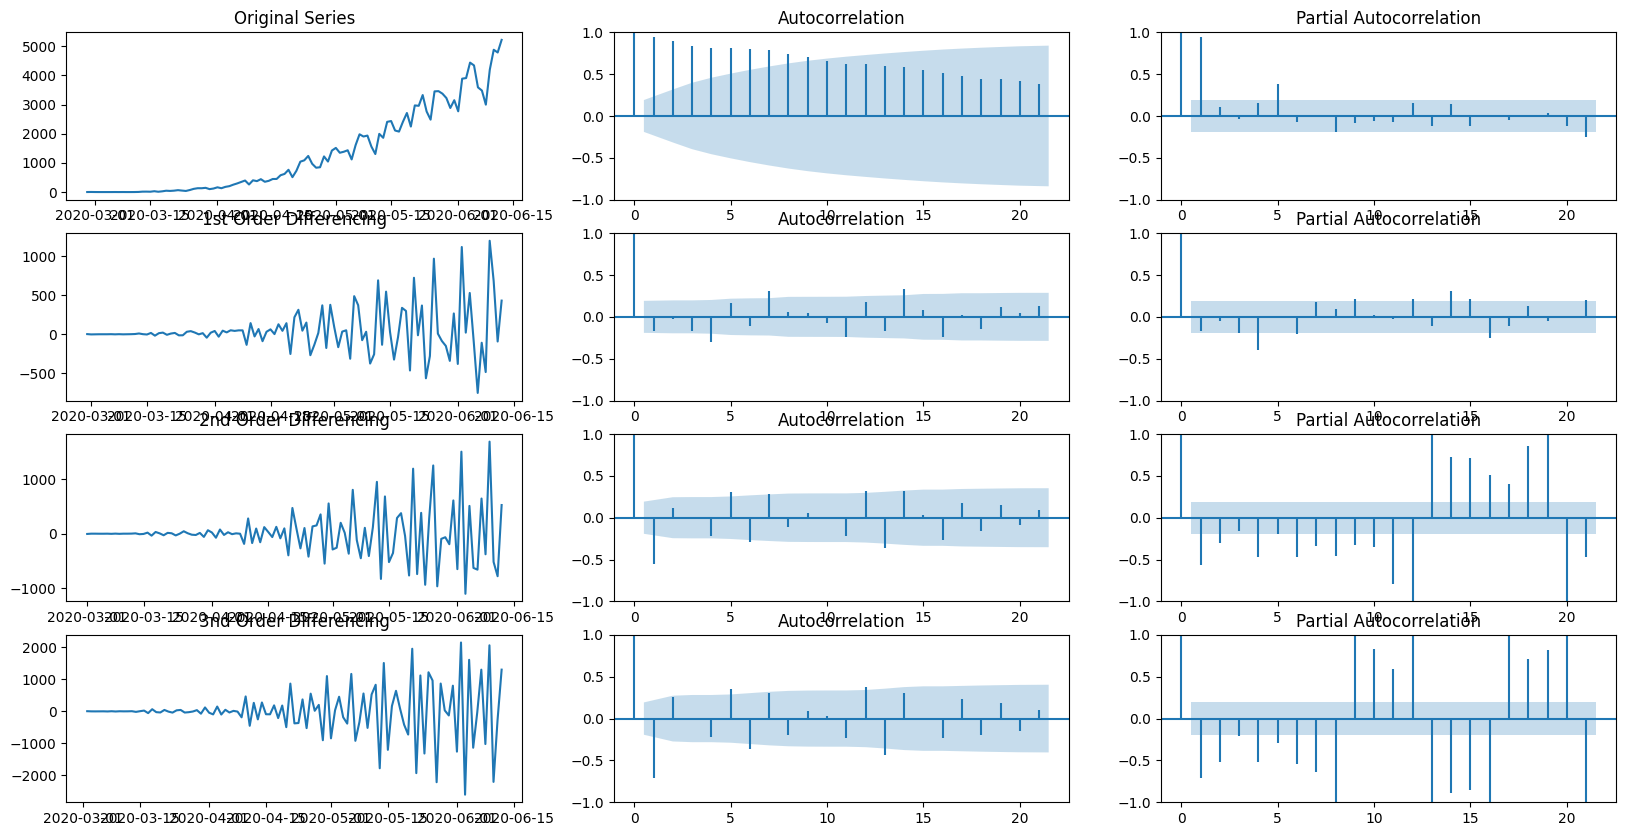

In [32]:
plot_diffs()

                               SARIMAX Results                                
Dep. Variable:              New cases   No. Observations:                  106
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -741.641
Date:                Fri, 09 Dec 2022   AIC                           1491.282
Time:                        21:19:48   BIC                           1501.860
Sample:                    02-28-2020   HQIC                          1495.567
                         - 06-12-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1702      0.069     -2.467      0.014      -0.305      -0.035
ar.L2         -0.0418      0.073     -0.575      0.566      -0.185       0.101
ma.L1         -0.9982      0.254     -3.932      0.0

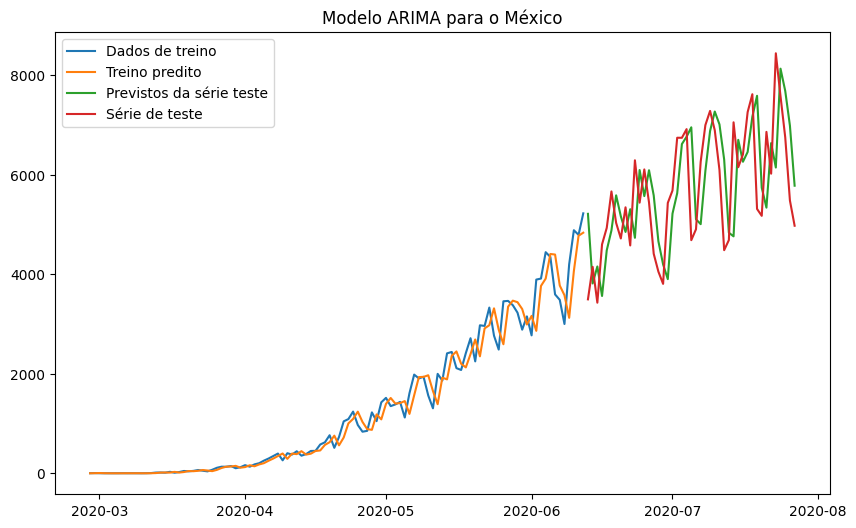

In [33]:
arima_model(train_data, test_data, p=2, d=2, q=1, model_name='ARIMA', country='México')

### Chile

#### Preparação dos dados

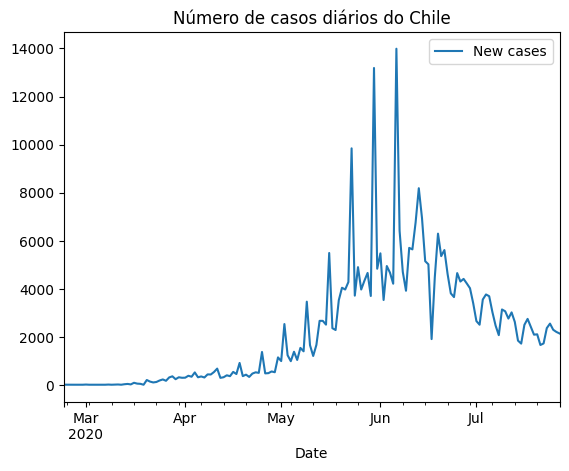

In [34]:
reg_data_ch = reg_data[reg_data['Country/Region'] == 'Chile']
reg_data_ch = reg_data_ch[['New cases']]
reg_data_ch = reg_data_ch.loc[reg_data_ch.ne(0).idxmax()[0]:]
reg_data_ch.plot()
plt.title('Número de casos diários do Chile');

In [35]:
print('Total de registros:', len(reg_data_ch))
print('Número de registros para treino:', round(len(reg_data_ch)*0.7, 0))
print('Número de registros para teste:', round(len(reg_data_ch)*0.3, 0))

Total de registros: 156
Número de registros para treino: 109.0
Número de registros para teste: 47.0


In [36]:
train_data = reg_data_ch.iloc[:109]
test_data = reg_data_ch.iloc[109:]
print('Número de registros para treino final:', len(train_data))
print('Número de registros para teste final:', len(test_data))

Número de registros para treino final: 109
Número de registros para teste final: 47


#### Modelo AR

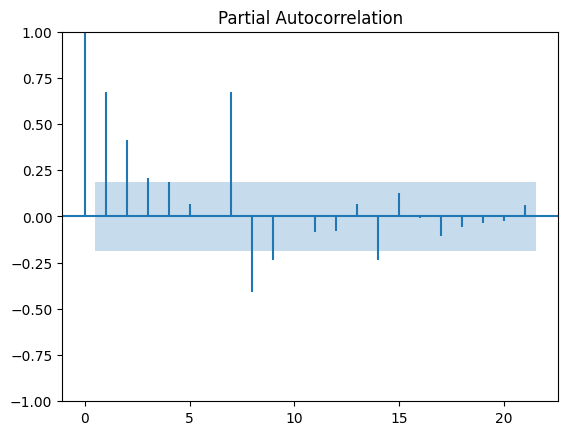

In [37]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_data['New cases'], marker='');

                               SARIMAX Results                                
Dep. Variable:              New cases   No. Observations:                  109
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -961.873
Date:                Fri, 09 Dec 2022   AIC                           1933.746
Time:                        21:20:23   BIC                           1947.203
Sample:                    02-23-2020   HQIC                          1939.203
                         - 06-10-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1661.1193   2918.415      0.569      0.569   -4058.868    7381.107
ar.L1          0.3113      0.120      2.588      0.010       0.076       0.547
ar.L2          0.3309      0.084      3.939      0.0

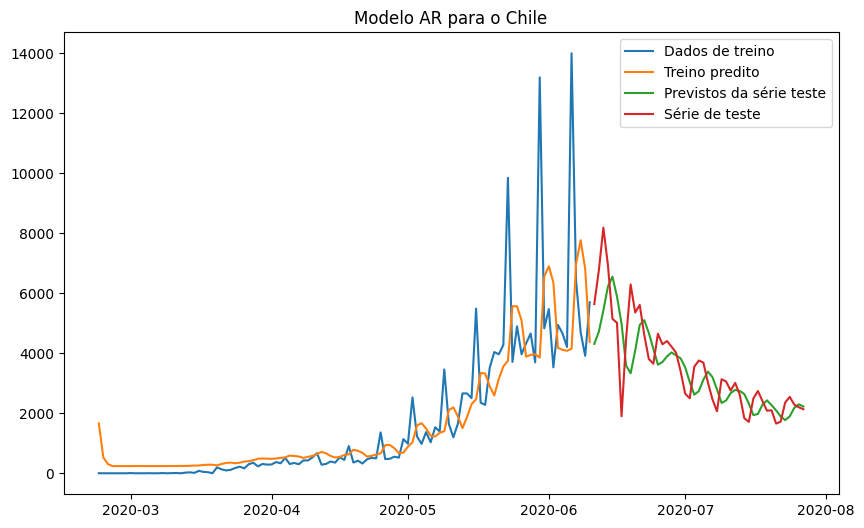

In [38]:
arima_model(train_data, test_data, p=3, model_name='AR', country='Chile')

#### Modelo MA

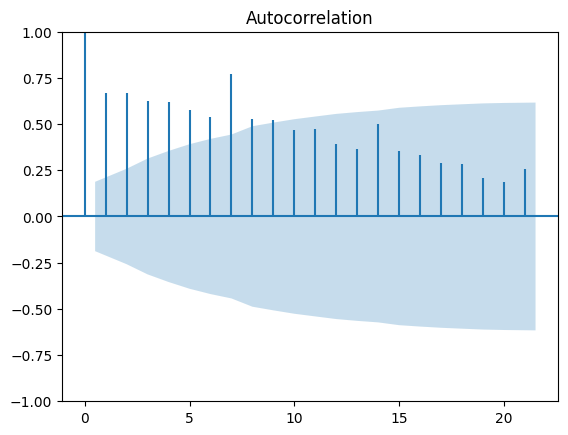

In [39]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train_data['New cases'],  marker='');

                               SARIMAX Results                                
Dep. Variable:              New cases   No. Observations:                  109
Model:                 ARIMA(0, 0, 7)   Log Likelihood                -928.134
Date:                Fri, 09 Dec 2022   AIC                           1874.267
Time:                        21:20:46   BIC                           1898.490
Sample:                    02-23-2020   HQIC                          1884.090
                         - 06-10-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1665.9569    938.669      1.775      0.076    -173.801    3505.715
ma.L1          0.4596      2.448      0.188      0.851      -4.338       5.257
ma.L2          0.4596      3.095      0.149      0.8

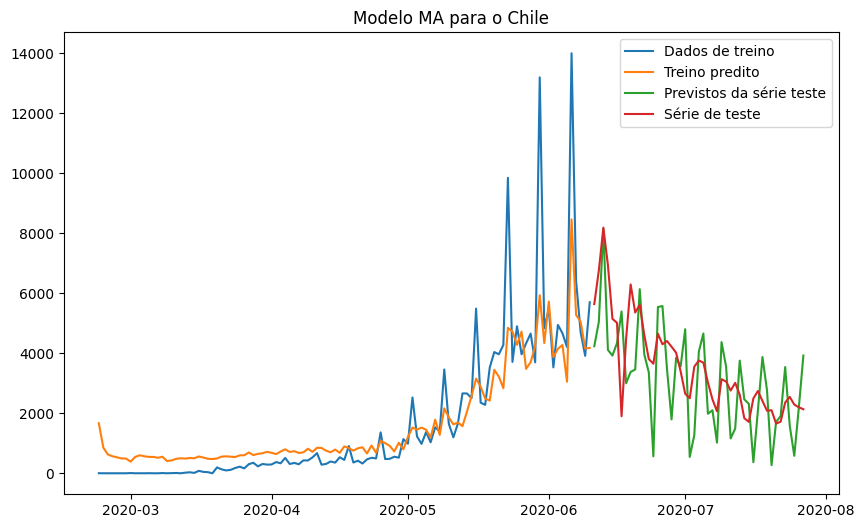

In [40]:
arima_model(train_data, test_data, q=7, model_name='MA', country='Chile')

#### Modelo ARIMA

ADF Statistic 0 Order: -0.431175
p-value: 0.904762
ADF Statistic 1st Order: -1.602649
p-value: 0.482263
ADF Statistic 2nd Order: -7.101183
p-value: 0.000000
ADF Statistic 3th order: -8.231663
p-value: 0.000000


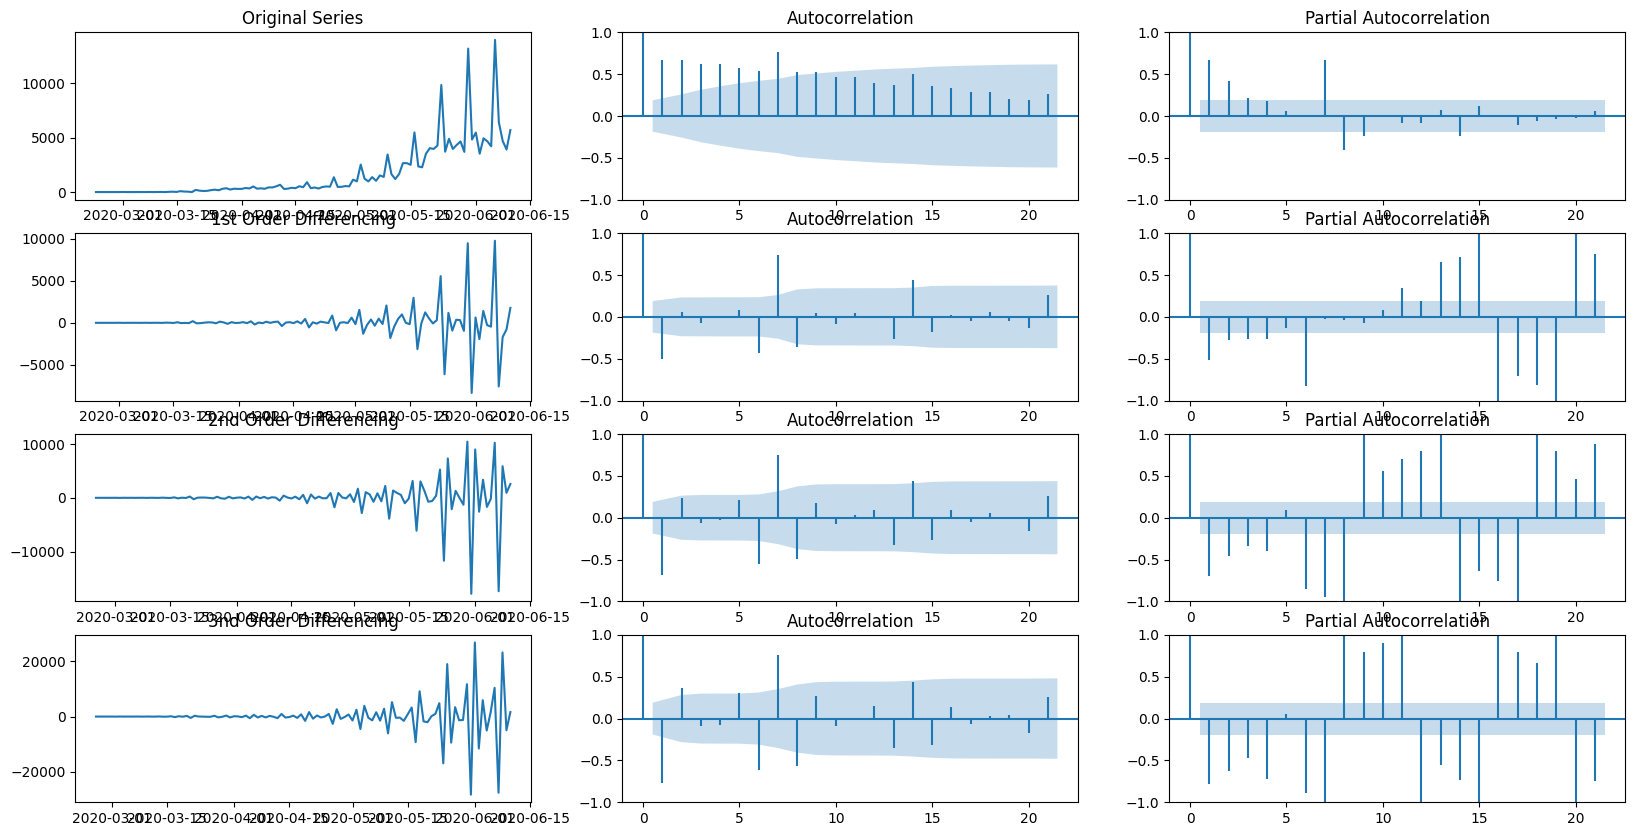

In [41]:
plot_diffs()

                               SARIMAX Results                                
Dep. Variable:              New cases   No. Observations:                  109
Model:                 ARIMA(4, 2, 1)   Log Likelihood                -941.126
Date:                Fri, 09 Dec 2022   AIC                           1894.252
Time:                        21:21:05   BIC                           1910.289
Sample:                    02-23-2020   HQIC                          1900.753
                         - 06-10-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7804      0.125     -6.267      0.000      -1.024      -0.536
ar.L2         -0.5646      0.127     -4.431      0.000      -0.814      -0.315
ar.L3         -0.4850      0.126     -3.850      0.0

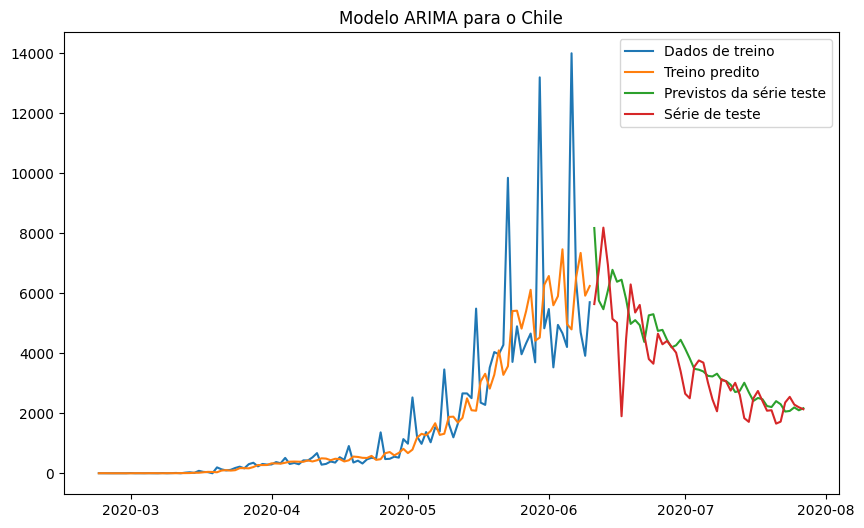

In [42]:
arima_model(train_data, test_data, p=4, d=2, q=1, model_name='ARIMA', country='Chile')

### Equador

#### Preparação dos dados

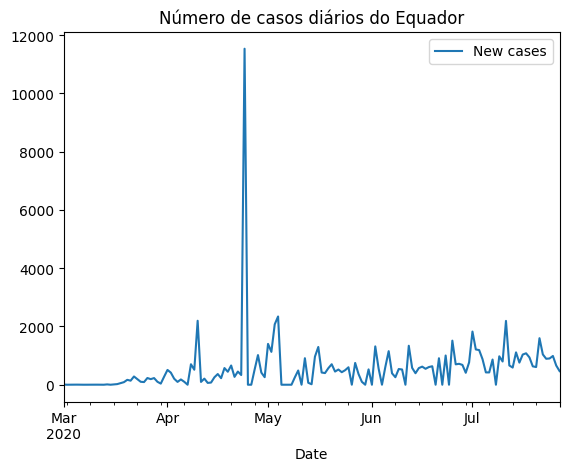

In [43]:
reg_data_eq = reg_data[reg_data['Country/Region'] == 'Ecuador']
reg_data_eq = reg_data_eq[['New cases']]
reg_data_eq = reg_data_eq.loc[reg_data_eq.ne(0).idxmax()[0]:]
reg_data_eq.plot()
plt.title('Número de casos diários do Equador');

In [44]:
print('Total de registros:', len(reg_data_eq))
print('Número de registros para treino:', round(len(reg_data_eq)*0.7, 0))
print('Número de registros para teste:', round(len(reg_data_eq)*0.3, 0))

Total de registros: 149
Número de registros para treino: 104.0
Número de registros para teste: 45.0


In [45]:
train_data = reg_data_eq.iloc[:104]
test_data = reg_data_eq.iloc[104:]
print('Número de registros para treino final:', len(train_data))
print('Número de registros para teste final:', len(test_data))

Número de registros para treino final: 104
Número de registros para teste final: 45


#### Modelo AR

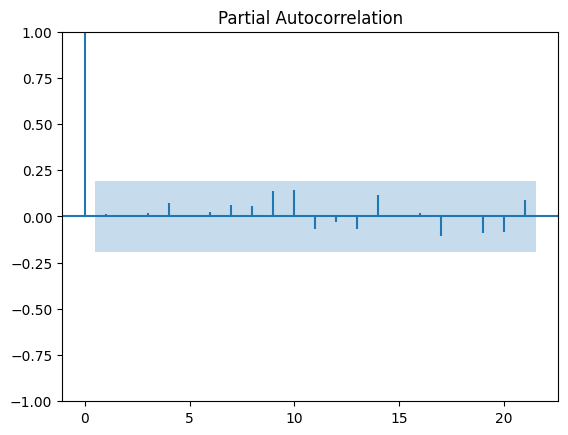

In [46]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_data['New cases'], marker='');

Não há autocorrelação parcial então não se aplica este modelo mas ainda assim será testado o modelo AR(1).

                               SARIMAX Results                                
Dep. Variable:              New cases   No. Observations:                  104
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -883.723
Date:                Fri, 09 Dec 2022   AIC                           1773.446
Time:                        21:21:40   BIC                           1781.379
Sample:                    03-01-2020   HQIC                          1776.660
                         - 06-12-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        470.1058    335.162      1.403      0.161    -186.799    1127.010
ar.L1          0.0146      0.185      0.079      0.937      -0.348       0.377
sigma2      1.418e+06   9.43e+04     15.043      0.0

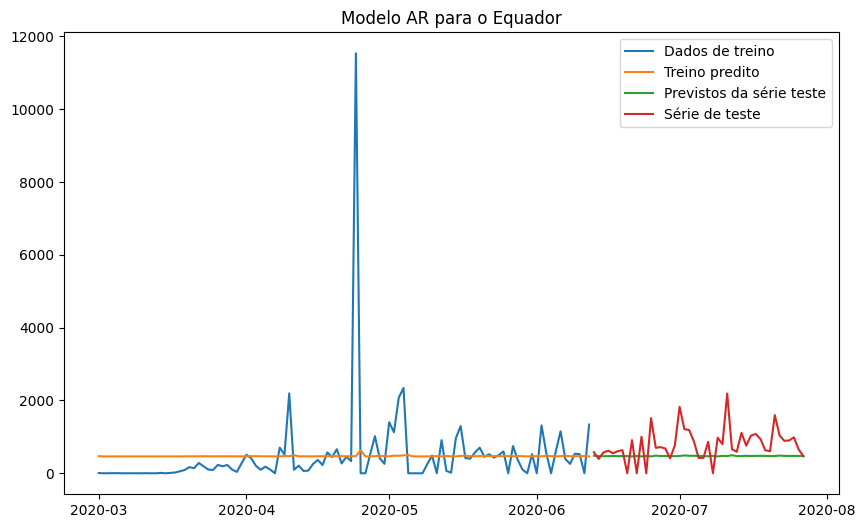

In [47]:
arima_model(train_data, test_data, p=1, model_name='AR', country='Equador')

#### Modelo MA

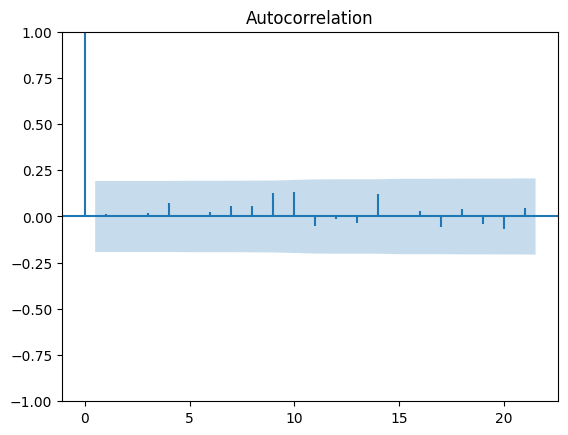

In [48]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train_data['New cases'], marker='');

                               SARIMAX Results                                
Dep. Variable:              New cases   No. Observations:                  104
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -883.750
Date:                Fri, 09 Dec 2022   AIC                           1773.500
Time:                        21:21:53   BIC                           1781.433
Sample:                    03-01-2020   HQIC                          1776.714
                         - 06-12-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        470.1058    343.320      1.369      0.171    -202.789    1143.000
ma.L1          0.0146      0.190      0.077      0.939      -0.357       0.386
sigma2      1.454e+06    9.9e+04     14.685      0.0

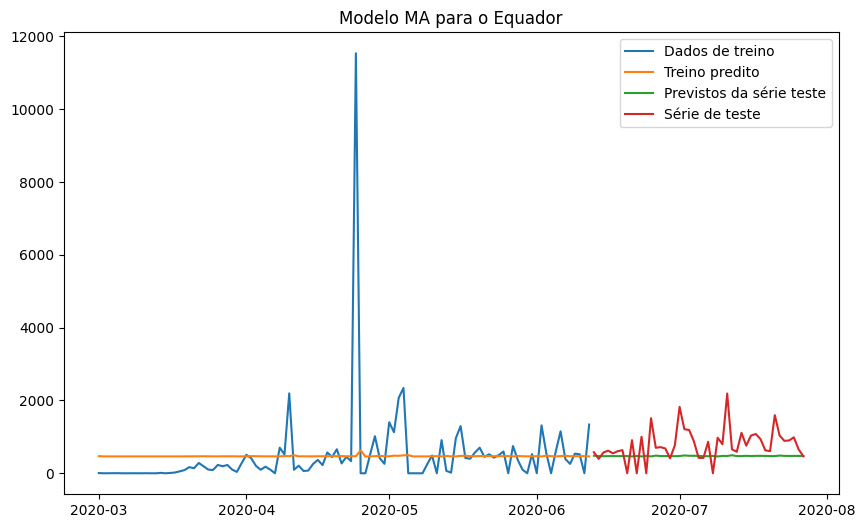

In [49]:
arima_model(train_data, test_data, q=1, model_name='MA', country='Equador')

#### Modelo ARIMA

ADF Statistic 0 Order: -9.884443
p-value: 0.000000
ADF Statistic 1st Order: -6.298609
p-value: 0.000000
ADF Statistic 2nd Order: -6.905006
p-value: 0.000000
ADF Statistic 3th order: -6.660682
p-value: 0.000000


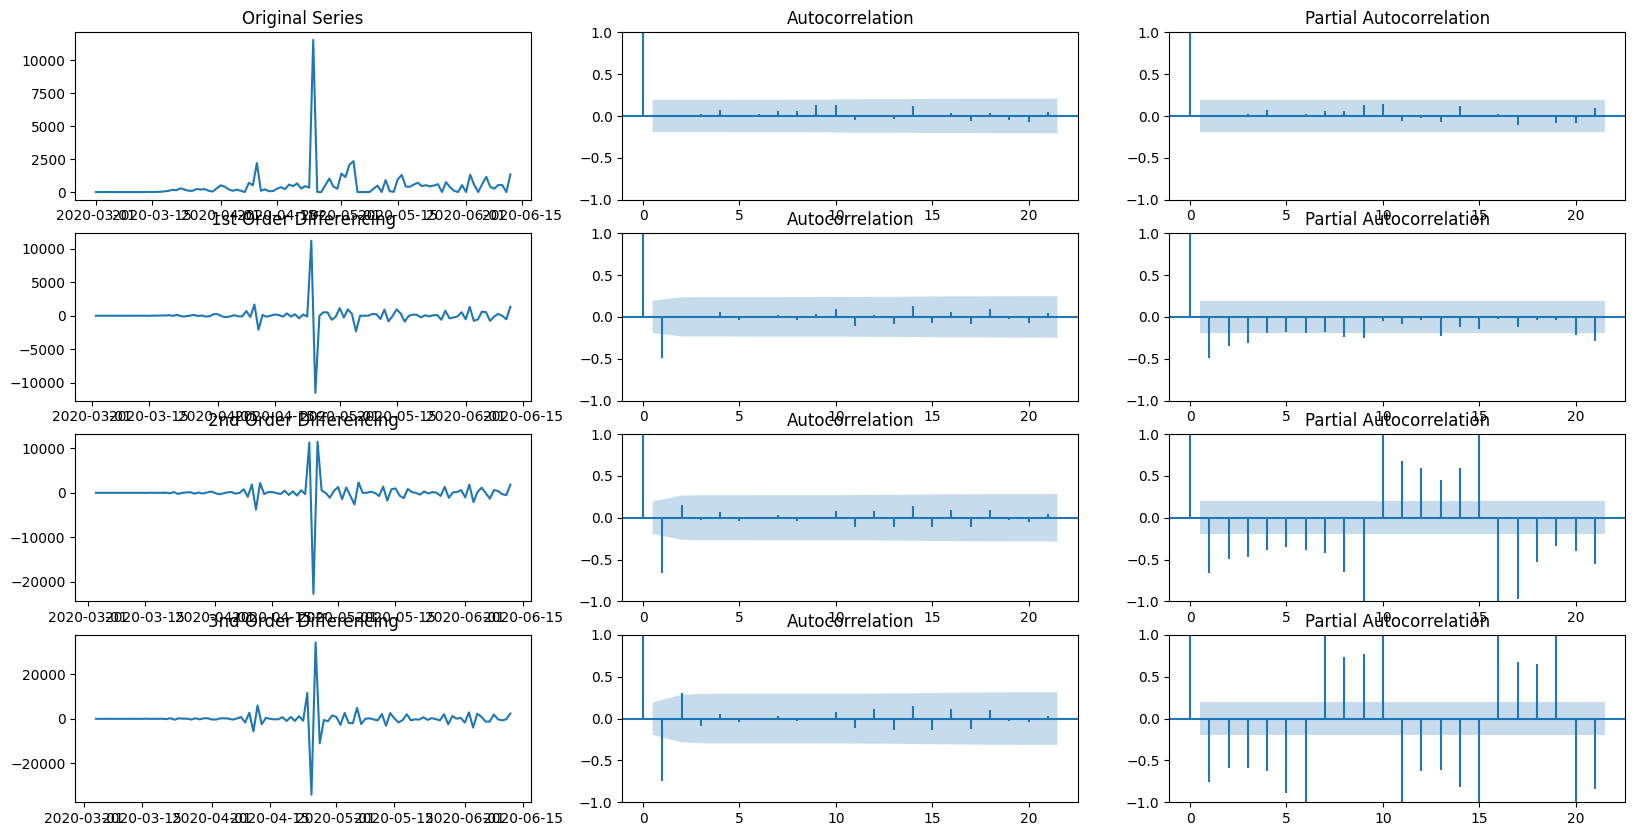

In [50]:
plot_diffs()

                               SARIMAX Results                                
Dep. Variable:              New cases   No. Observations:                  104
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -883.749
Date:                Fri, 09 Dec 2022   AIC                           1775.499
Time:                        21:22:10   BIC                           1786.076
Sample:                    03-01-2020   HQIC                          1779.784
                         - 06-12-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        470.1059    348.268      1.350      0.177    -212.486    1152.698
ar.L1         -0.0703     17.843     -0.004      0.997     -35.042      34.901
ma.L1          0.0852     17.839      0.005      0.9

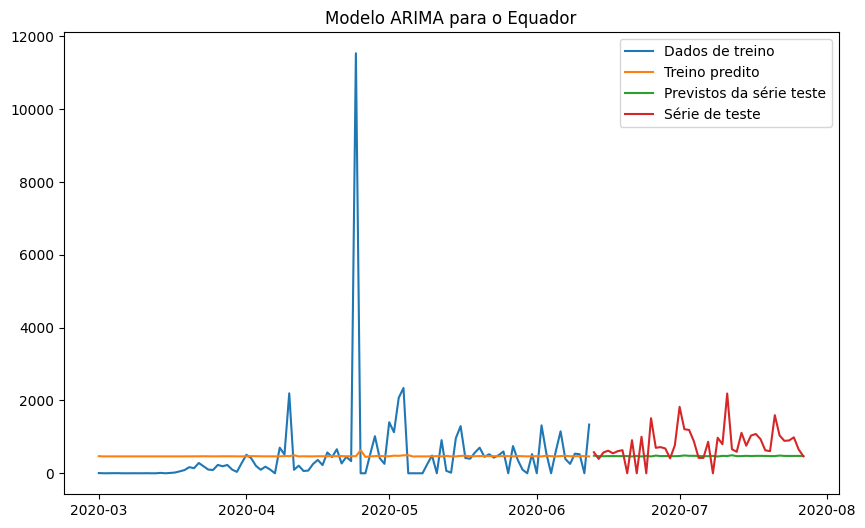

In [51]:
arima_model(train_data, test_data, p=1, q=1, model_name='ARIMA', country='Equador')

### Espanha

#### Preparação dos dados

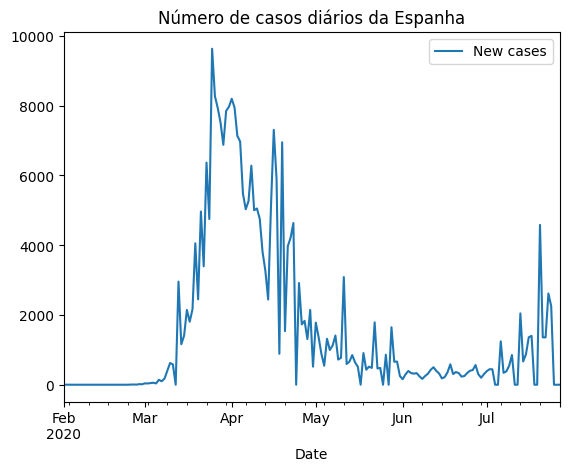

In [52]:
reg_data_es = reg_data[reg_data['Country/Region'] == 'Spain']
reg_data_es = reg_data_es[['New cases']]
reg_data_es = reg_data_es.loc[reg_data_es.ne(0).idxmax()[0]:]
reg_data_es.plot()
plt.title('Número de casos diários da Espanha');

In [53]:
print('Total de registros:', len(reg_data_es))
print('Número de registros para treino:', round(len(reg_data_es)*0.7, 0))
print('Número de registros para teste:', round(len(reg_data_es)*0.3, 0))

Total de registros: 178
Número de registros para treino: 125.0
Número de registros para teste: 53.0


In [54]:
train_data = reg_data_es.iloc[:125]
test_data = reg_data_es.iloc[125:]
print('Número de registros para treino final:', len(train_data))
print('Número de registros para teste final:', len(test_data))

Número de registros para treino final: 125
Número de registros para teste final: 53


#### Modelo AR

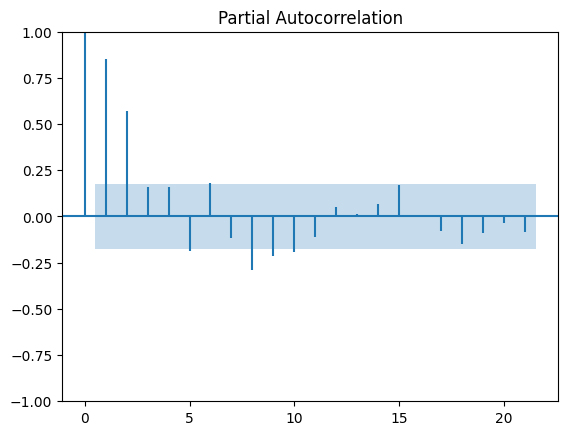

In [55]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_data['New cases'], marker='');

                               SARIMAX Results                                
Dep. Variable:              New cases   No. Observations:                  125
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1056.737
Date:                Fri, 09 Dec 2022   AIC                           2121.474
Time:                        21:22:45   BIC                           2132.787
Sample:                    02-01-2020   HQIC                          2126.070
                         - 06-04-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2008.5278   1892.581      1.061      0.289   -1700.862    5717.918
ar.L1          0.3804      0.056      6.827      0.000       0.271       0.490
ar.L2          0.5483      0.052     10.550      0.0

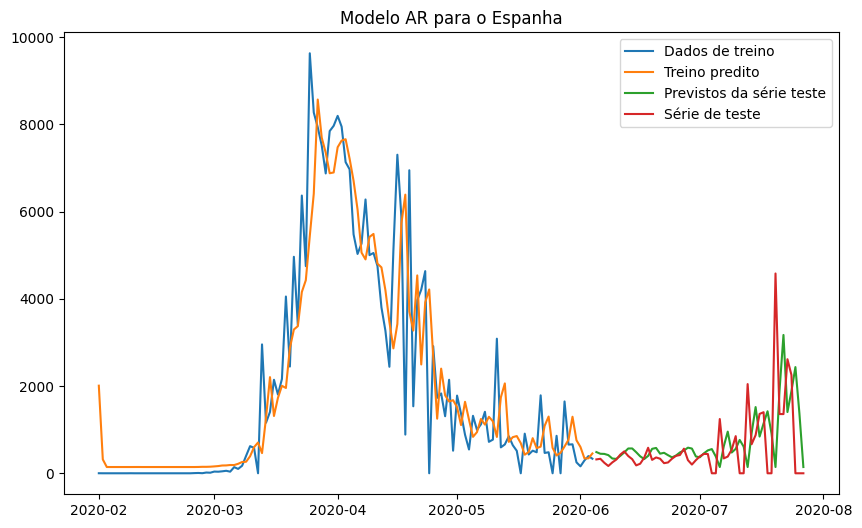

In [56]:
arima_model(train_data, test_data, p=2, model_name='AR', country='Espanha')

#### Modelo MA

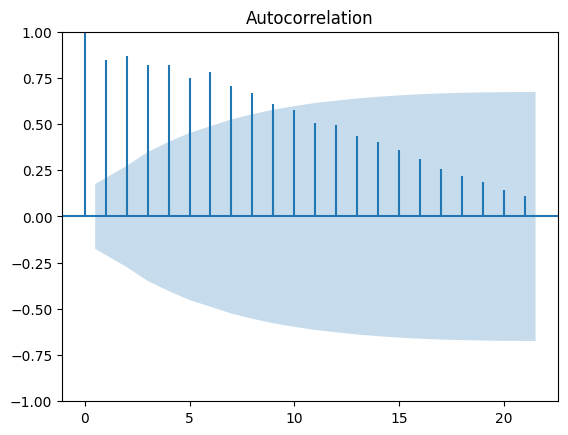

In [57]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train_data['New cases'], marker='');

                               SARIMAX Results                                
Dep. Variable:              New cases   No. Observations:                  125
Model:                 ARIMA(0, 0, 8)   Log Likelihood               -1066.305
Date:                Fri, 09 Dec 2022   AIC                           2152.609
Time:                        21:23:16   BIC                           2180.893
Sample:                    02-01-2020   HQIC                          2164.099
                         - 06-04-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2004.5964    656.419      3.054      0.002     718.039    3291.154
ma.L1          0.1300      0.191      0.680      0.497      -0.245       0.505
ma.L2          0.6390      0.096      6.629      0.0

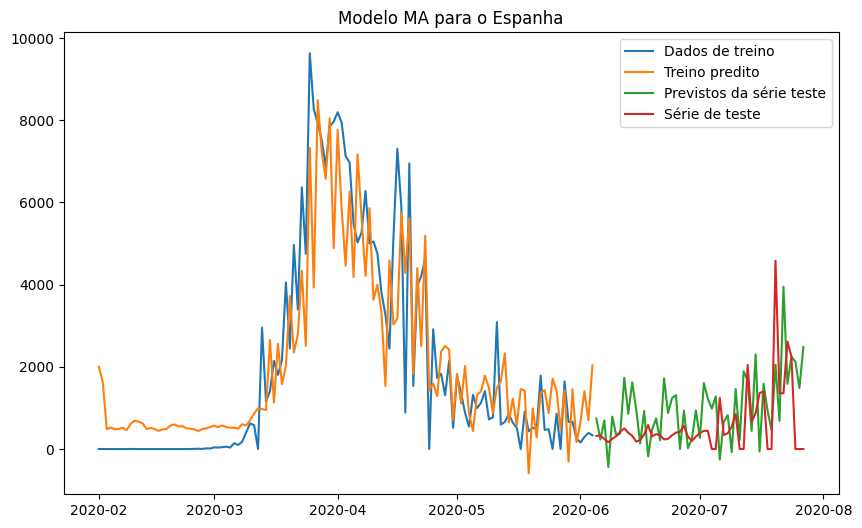

In [58]:
arima_model(train_data, test_data, q=8, model_name='MA', country='Espanha')

#### Modelo ARIMA

ADF Statistic 0 Order: -2.104210
p-value: 0.242825
ADF Statistic 1st Order: -2.739060
p-value: 0.067520
ADF Statistic 2nd Order: -8.047828
p-value: 0.000000
ADF Statistic 3th order: -7.523316
p-value: 0.000000


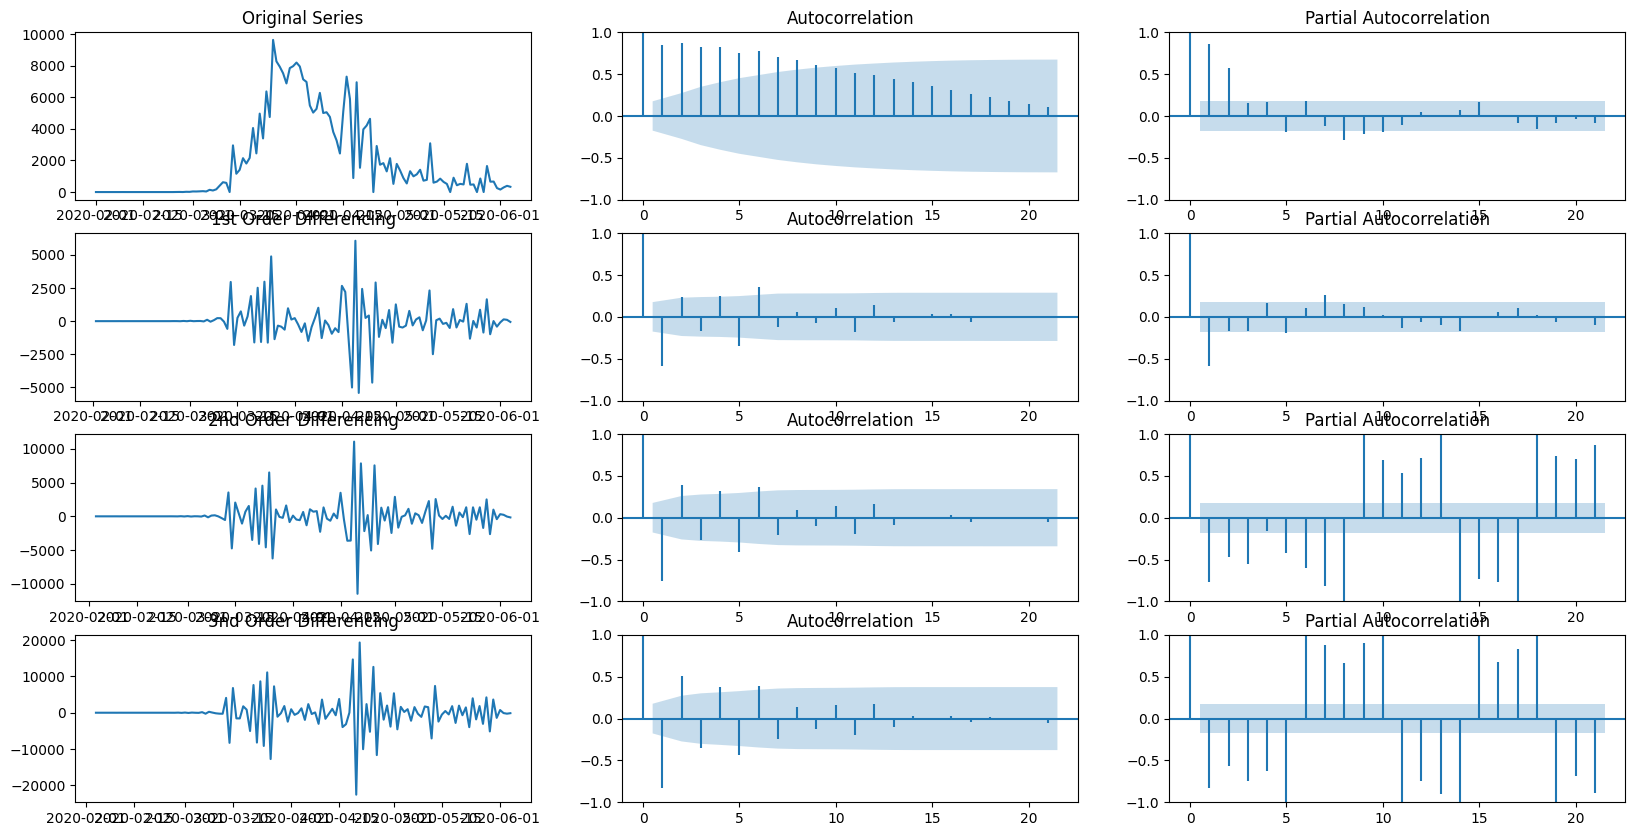

In [59]:
plot_diffs()

                               SARIMAX Results                                
Dep. Variable:              New cases   No. Observations:                  125
Model:                 ARIMA(3, 2, 2)   Log Likelihood               -1037.414
Date:                Fri, 09 Dec 2022   AIC                           2086.828
Time:                        21:24:03   BIC                           2103.701
Sample:                    02-01-2020   HQIC                          2093.682
                         - 06-04-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3095      0.223     -5.881      0.000      -1.746      -0.873
ar.L2         -0.7381      0.180     -4.101      0.000      -1.091      -0.385
ar.L3         -0.3218      0.057     -5.656      0.0

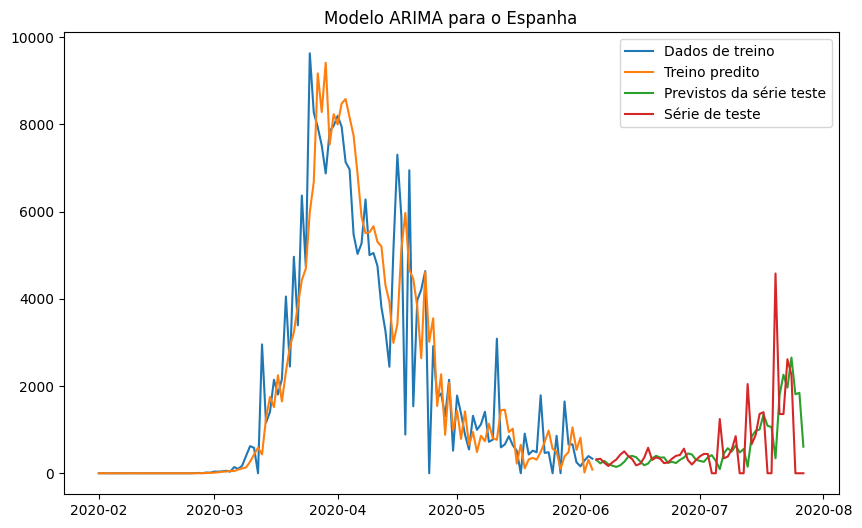

In [60]:
arima_model(train_data, test_data, p=3, d=2, q=2, model_name='ARIMA', country='Espanha')